In this last part of the project we're going to implement clustering on the text data of our dataset using **K-Means clustering!** 

In [64]:
#importing libraries

import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
import random
from scipy import stats
import sklearn
import csv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Data exploration

In [3]:
filename = "/home/andrewpap22/Desktop/DataScience-testDir/Data/train_set.csv"
dataframe = pd.read_csv(filename)
dataframe.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
dataframe.tail()

,ArticleId,Text,Category
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech
1489,538,santy worm makes unwelcome visit thousands of ...,tech


In [5]:
n_category = len(np.unique(dataframe.Category))
n_news = len(dataframe.Text)
print('Total no. of categories: ' + str(n_category))
print('Total no. of news: ' + str(n_news))

Total no. of categories: 5
Total no. of news: 1490


Keep in mind that, this is not the whole dataset, but the train set of the whole dataset that was made in previous parts of the project, since we're asked to cluster on the train data

# Processing the data

In [6]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [7]:
WN_lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(WN_lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [8]:
bad_chars = ['#','%','@','=','+',';', ':','!','*','?','$','1','2','3','4','5','6','7','8','9','0','-','&','>','<','/']

In [11]:
for i in range(n_news):
    text = str(dataframe['Text'][i])
    text = ''.join(i for i in text if not i in bad_chars) 
    text = lemmatize_sentence(text)
    dataframe['Text'][i] = str(text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
dataframe.head()

,ArticleId,Text,Category
0,1833,worldcom exboss launch defence lawyer defend f...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicate economic gloom citizen in a ...,business
3,1976,lifestyle governs mobile choice faster well or...,tech
4,917,enron bos in m payout eighteen former enron di...,business


# Vectorizing using TF-IDF

In [13]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform([i for i in dataframe.Text[0:2225]]) #will change it later
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
tfidf = pd.DataFrame(dense, columns=feature_names)
print(tfidf.shape)

(1490, 20408)


In [14]:
tfidf.head()

,aa,aaa,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,abandon,...,zombie,zone,zonealarm,zoom,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
T_svd = TruncatedSVD(n_components=2000,random_state = 0)   #(Dimensionality Reduction) TruncatedSVD for sparse data
T_svd_res = T_svd.fit_transform(tfidf)

# Finding optimal number of clusters(K) using Elbow Method

1 1449.7057509370004
2 1434.7554475429597
3 1422.802899817612
4 1412.4217919587031
5 1403.3758135288228
6 1396.0727251301623
7 1390.7177554676182
8 1384.0836270412692
9 1378.2322944082543
10 1373.6987245013515
11 1369.6188453390928


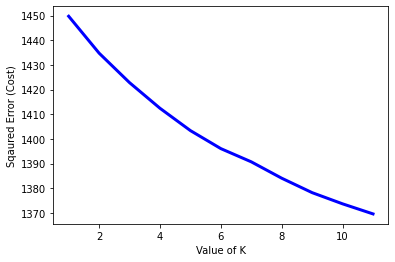

In [17]:
cost = []
for k in range(1,12):
    kmeanModel= KMeans(n_clusters=k,n_init=30,max_iter=200) 
    kmeanModel.fit(T_svd_res)
    cost.append(kmeanModel.inertia_) 
    print(k,cost[k-1])
plt.plot(range(1,12), cost, color ='b', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

So, using the Elbow Method, we found out that the optimal number of clusters is 5, as asked in the project definition, so we're good to go, clustering using k-means with k = 5 clusters! 

# Clustering using K-means (with optimal value of K) 

In [18]:
K = 5
kmeanModel= KMeans(n_clusters=K,verbose=0,n_init=30,max_iter=300)
kmeanModel.fit(T_svd_res)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [19]:
y_pred = kmeanModel.predict(T_svd_res)

# Dimensionality reduction using TruncatedSVD for cluster visualization

In [20]:
svd_res = TruncatedSVD(n_components=2,random_state = 0)
svd_res = svd_res.fit_transform(tfidf)

In [22]:
clr = ['Blue','Green','Red','Darkgray','Yellow']
area = np.pi*7

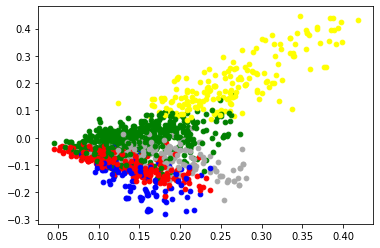

In [23]:
for i in range(svd_res.shape[0]):
    X = svd_res[:,0][i]
    Y = svd_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Dimensionality Reduction using Principal of Component Analysis (PCA) for cluster visualization

In [26]:
pca_res = PCA(n_components=2,svd_solver='auto', random_state=0)
pca_res = pca_res.fit_transform(tfidf)

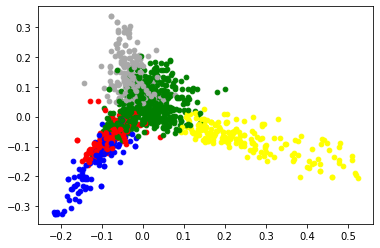

In [27]:
for i in range(pca_res.shape[0]):
    X = pca_res[:,0][i]
    Y = pca_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Dimensionality reduction using Independent Component Analysis (FastICA) for cluster visualization

In [29]:
ica_res = FastICA(n_components=2, random_state=0)
ica_res = ica_res.fit_transform(tfidf)

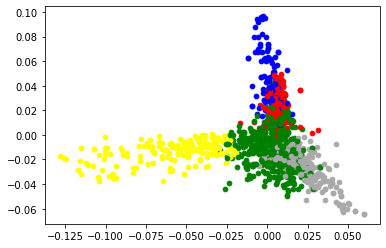

In [30]:
for i in range(ica_res.shape[0]):
    X = ica_res[:,0][i]
    Y = ica_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

At this point, we're done with the 3 dimensionality reduction techniques required from the project definition:
1. **PCA**
2. **SVD**
3. **ICA** 

Implementing the 3 of them we're getting a **bonus** (as told in project definition). But I'll coninue here with implementing 2 more: **(1. UMAP, 2.T-SNE)** 

Later on I'll try to prepare the data for **Embedding Projector** (tensorflow) So we can see our clustering visualization in a more.. **'wow'** way... 

And lastly I'm going to calculate the Accuracy and at that point the clustering on our dataset is done and since it is the last point of the project, the project will be completed with all parts, bonus parts completed!!! 

# Dimensionality reduction using T-SNE for cluster visualization

In [31]:
tsne = TSNE(n_components=2, perplexity=100, early_exaggeration=12.0, learning_rate=100.0,
                n_iter=700, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
                init='random', verbose=1, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
tsne_results = tsne.fit_transform(tfidf)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1490 samples in 1.734s...
[t-SNE] Computed neighbors for 1490 samples in 75.884s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1490
[t-SNE] Computed conditional probabilities for sample 1490 / 1490
[t-SNE] Mean sigma: 0.329055
[t-SNE] KL divergence after 100 iterations with early exaggeration: 60.186134
[t-SNE] KL divergence after 700 iterations: 1.002587


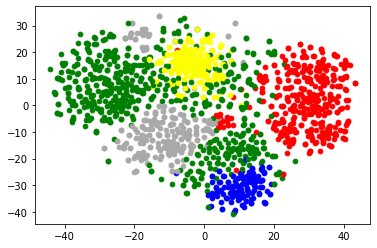

In [32]:
for i in range(tsne_results.shape[0]):
    X = tsne_results[:,0][i]
    Y = tsne_results[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Dimensionality reduction using UMAP for cluster visualization

In [66]:
UMAP_res = umap.UMAP(n_components=2,n_neighbors=301,
                     min_dist=0.9,metric='cosine',
                     n_epochs=200).fit_transform(tfidf)

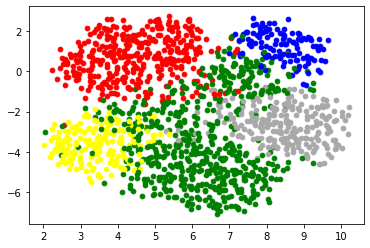

In [67]:
for i in range(UMAP_res.shape[0]):
    X = UMAP_res[:,0][i]
    Y = UMAP_res[:,1][i]
    plt.scatter(X,Y,s=area,color=clr[y_pred[i]])
plt.show()

# Preparing data for Embedding Projector

* [Embedding Projector](http://projector.tensorflow.org)

In [72]:
labels = y_pred[0:n_news]
labels = pd.DataFrame(labels)
labels.to_csv('/home/andrewpap22/Desktop/DataScience-testDir/clustering/label.csv',
              index=False,header=False)

In [73]:
filename = '/home/andrewpap22/Desktop/DataScience-testDir/clustering/label.csv'
with open(filename,'r') as csvin, open('clustering/label.txt', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)
pre, ext = os.path.splitext('clustering/label.txt')
os.rename('clustering/label.txt', pre + '.tsv')

well, now it seems i managed to create the tsv file without the libre office crashing when opening the file as in part 1 of the project... 

In [74]:
tfidf_1 = umap.UMAP(n_components=200,
                    n_neighbors=301,min_dist=0.9,
                    metric='cosine',n_epochs=200).fit_transform(tfidf)

In [75]:
t = pd.DataFrame(tfidf_1[0:n_news].copy())
t.to_csv('clustering/embed.csv',index=False,header=False)

In [76]:
with open('clustering/embed.csv','r') as csvin, open('clustering/embed.txt', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')

    for row in csvin:
        tsvout.writerow(row)
pre, ext = os.path.splitext('clustering/embed.txt')
os.rename('clustering/embed.txt', pre + '.tsv')

# Embedding Projector Output 

1. **Visualization of clusters (without labels) :**
    
![WithoutLabels](img/img1.gif)

2. **Visualization of clusters (with labels):**

![WithLabels](img/img2.gif)

# Calculating Accuracy

In [77]:
dataframe['cluster'] = y_pred
dataframe.head()

,ArticleId,Text,Category,cluster
0,1833,worldcom exboss launch defence lawyer defend f...,business,1
1,154,german business confidence slides german busin...,business,1
2,1101,bbc poll indicate economic gloom citizen in a ...,business,1
3,1976,lifestyle governs mobile choice faster well or...,tech,3
4,917,enron bos in m payout eighteen former enron di...,business,1


In [78]:
dataframe.tail()

,ArticleId,Text,Category,cluster
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hit reuters revenue at medium grou...,business,1
1488,1587,apple ipod family expand market apple have exp...,tech,3
1489,538,santy worm make unwelcome visit thousand of we...,tech,3


In [79]:
# accuracy calculation: 

accuracy = 0
#check for every of the 5 clusters (k=5)
for i in range(K): 
    temp_df = dataframe[dataframe['cluster'] == i]
    cat_mode = stats.mode(np.array(temp_df.Category))
    print(cat_mode.mode[0],cat_mode.count[0],len(temp_df.Category))
    accuracy = accuracy + (cat_mode.count[0]/len(temp_df.Category))
print('Accuracy (Method 1) : '+str(round((accuracy/5)*100,2))+'%')     

accuracy2 = 0
category = ['business','entertainment','politics','sport','tech']

#check for all 5 categories
for i in category:
    temp_df = dataframe[dataframe['Category'] == i]
    cat_mode = stats.mode(np.array(temp_df.cluster))
    print(cat_mode.mode[0],cat_mode.count[0],len(temp_df.cluster))
    accuracy2 = accuracy2 + (cat_mode.count[0]/len(temp_df.cluster))  
print('Accuracy (Method 2) : '+str(round((accuracy2/5)*100,2))+'%')

#avg accuracy
print('Final Accuracy : '+str(round(((accuracy+accuracy2)/10)*100,2))+'%')

entertainment 119 123
business 330 591
sport 338 361
tech 224 233
politics 180 182
Accuracy (Method 1) : 88.25%
1 330 336
1 147 273
4 180 274
2 338 346
3 224 261
Accuracy (Method 2) : 80.25%
Final Accuracy : 84.25%


**--------------------------------------------------------------------------------------------------------**

__*At this point we're done with our DataMining Project of spring semester 2020, implementing all of the 4 requirements of the project + the bonuses*__ 

*Student:* **Andreas Pappas**

*ID:* **1115201500201**